# Filter Snapshot Clustering (Kalman / Wiener / SavGol / SMURF)

This notebook builds a feature dataset where, for a single snapshot date, each asset is represented by the **filtered close** values:
- Kalman filter (`smooth_kalman`)
- Wiener filter (`smooth_wiener`)
- Savitzky-Golay filter (`smooth_savgol`)
- SMURF-like smoothing (`smurf_smoothing`)

Clustering algorithms:
- KMeans
- DBSCAN
- Gaussian Mixture Model (GMM)

Outputs:
- cluster memberships for each algorithm
- daily price charts for each cluster (full history) with **asset names in the legend**

Time split:
- snapshot date is the **last date in the training window** (first 7 years)
- charts use full available history


In [3]:
from __future__ import annotations

from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler



In [4]:
# Resolve project root robustly
CWD = Path.cwd().resolve()
PROJECT_ROOT = None
for p in [CWD, *CWD.parents]:
    if (p / 'dataset').exists() and (p / 'src').exists():
        PROJECT_ROOT = p
        break
if PROJECT_ROOT is None:
    raise RuntimeError(f'Could not locate project root from CWD={CWD}')
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
    import os
    os.chdir(PROJECT_ROOT)

from src.cleaning.filters import smooth_kalman, smooth_wiener
from src.cleaning.smoothing import smooth_savgol
from src.cleaning.advanced import smurf_smoothing
print('PROJECT_ROOT:', PROJECT_ROOT)


PROJECT_ROOT: /home/anivarth/college/quant-task


In [5]:
from src.backtester.data import load_cleaned_assets, align_close_prices

assets_ohlcv = load_cleaned_assets(cleaned_dir=str(PROJECT_ROOT / 'dataset' / 'cleaned'))
close_daily = align_close_prices(assets_ohlcv).sort_index().ffill().bfill()

TRAIN_YEARS = 7
TEST_MONTHS = 18
start = pd.Timestamp(close_daily.index.min())
end = pd.Timestamp(close_daily.index.max())
train_end = start + pd.DateOffset(years=TRAIN_YEARS)
test_start = end - pd.DateOffset(months=TEST_MONTHS)

if train_end >= test_start:
    raise ValueError('Not enough history for requested time split')

# Snapshot date: last available daily bar within the training window
train_close = close_daily.loc[:train_end]
if train_close.empty:
    raise ValueError('Empty train_close after slicing to train_end')

snapshot_dt = pd.Timestamp(train_close.index.max())
print('date range:', start.date(), '->', end.date())
print('train_end:', train_end.date(), 'snapshot_dt:', snapshot_dt.date(), 'test_start:', test_start.date())


date range: 2016-01-25 -> 2026-01-16
train_end: 2023-01-25 snapshot_dt: 2023-01-25 test_start: 2024-07-16


In [6]:
# Feature dataset at snapshot_dt: filtered close values per asset

KALMAN_R = 0.1
KALMAN_Q = 0.01
WIENER_SIZE = 5
SAVGOL_WINDOW = 11
SAVGOL_POLYORDER = 2
SMURF_WINDOW = 10

rows = []
assets = list(train_close.columns)

for sym in assets:
    s = train_close[sym].astype(float)
    if s.isna().all():
        continue

    # Compute smoothers on the training window only
    k = smooth_kalman(s, r=KALMAN_R, q=KALMAN_Q)
    w = smooth_wiener(s, mysize=WIENER_SIZE)
    g = smooth_savgol(s, window=SAVGOL_WINDOW, polyorder=SAVGOL_POLYORDER)
    m = smurf_smoothing(s, window=SMURF_WINDOW)

    # Take values at snapshot_dt (safe because snapshot_dt is within index)
    rows.append(
        {
            'Asset_ID': sym,
            'kalman': float(k.loc[snapshot_dt]),
            'wiener': float(w.loc[snapshot_dt]),
            'savgol': float(g.loc[snapshot_dt]),
            'smurf': float(m.loc[snapshot_dt]),
        }
    )

feat = pd.DataFrame(rows).set_index('Asset_ID').replace([np.inf, -np.inf], np.nan).dropna()
print('feat shape:', feat.shape)
display(feat.head())


feat shape: (100, 4)


,kalman,wiener,savgol,smurf
Asset_ID,,,,
Asset_001,174.900172,177.205496,179.285388,180.158251
Asset_002,324.364150,325.007918,326.159413,329.327588
Asset_003,98.841338,99.126266,101.583683,102.053655
Asset_004,110.020616,110.285023,110.237417,111.188906
Asset_005,24.075806,25.147257,25.528539,25.650658


In [7]:
# Standardize and cluster

X = feat.to_numpy(dtype=float)
scaler = StandardScaler()
Xz = scaler.fit_transform(X)

# 1) KMeans
N_CLUSTERS = 8
km = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
km_labels = km.fit_predict(Xz)

# 2) DBSCAN (eps is scale-dependent)
EPS = 1.2
MIN_SAMPLES = 3

db = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES)
db_labels = db.fit_predict(Xz)

# 3) GMM

gmm = GaussianMixture(n_components=N_CLUSTERS, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(Xz)

assets_fit = feat.index.to_list()

def labels_to_groups(labels: np.ndarray) -> dict[int, list[str]]:
    groups: dict[int, list[str]] = {}
    for a, lab in zip(assets_fit, labels):
        groups.setdefault(int(lab), []).append(a)
    return groups

km_groups = labels_to_groups(km_labels)
db_groups = labels_to_groups(db_labels)
gmm_groups = labels_to_groups(gmm_labels)

print('snapshot_dt:', snapshot_dt)
print('KMeans sizes:', {k: len(v) for k, v in km_groups.items()})
print('DBSCAN labels:', sorted(db_groups.keys()), 'noise(-1)=', len(db_groups.get(-1, [])))
print('GMM sizes:', {k: len(v) for k, v in gmm_groups.items()})


snapshot_dt: 2023-01-25 00:00:00
KMeans sizes: {3: 18, 5: 14, 6: 27, 0: 26, 1: 9, 4: 4, 7: 1, 2: 1}
DBSCAN labels: [-1, 0] noise(-1)= 2
GMM sizes: {4: 21, 3: 13, 0: 21, 5: 34, 7: 5, 1: 4, 6: 1, 2: 1}


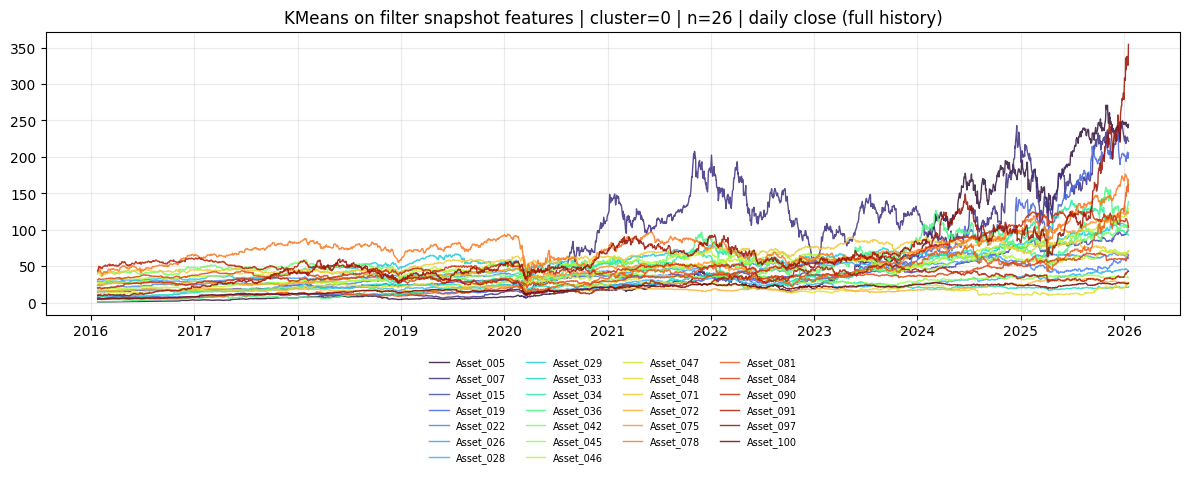

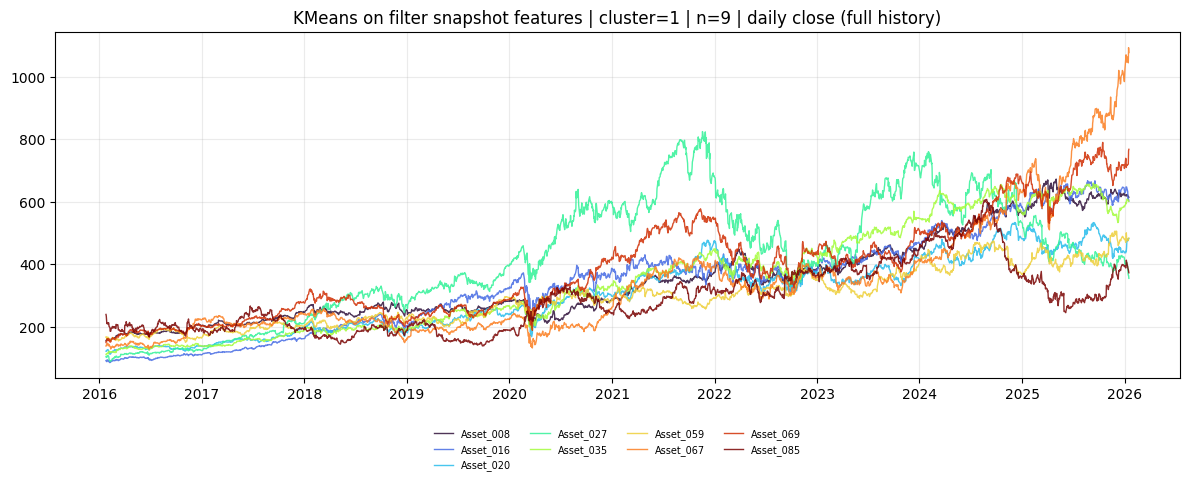

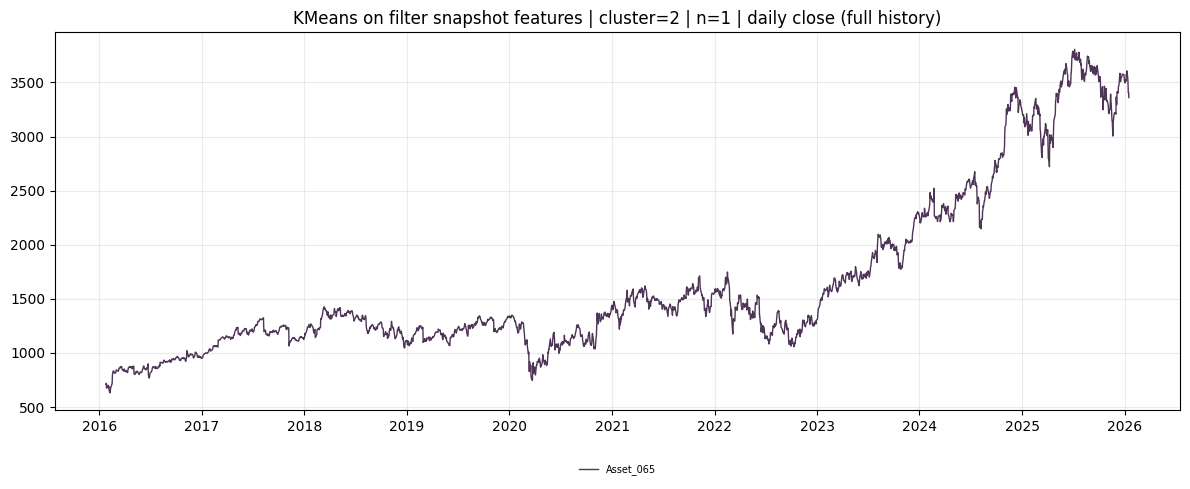

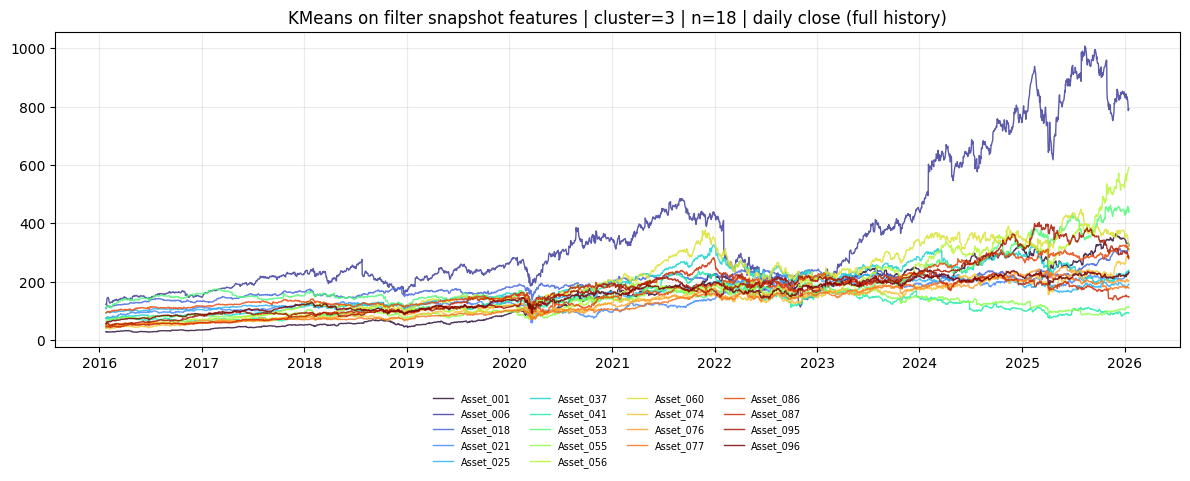

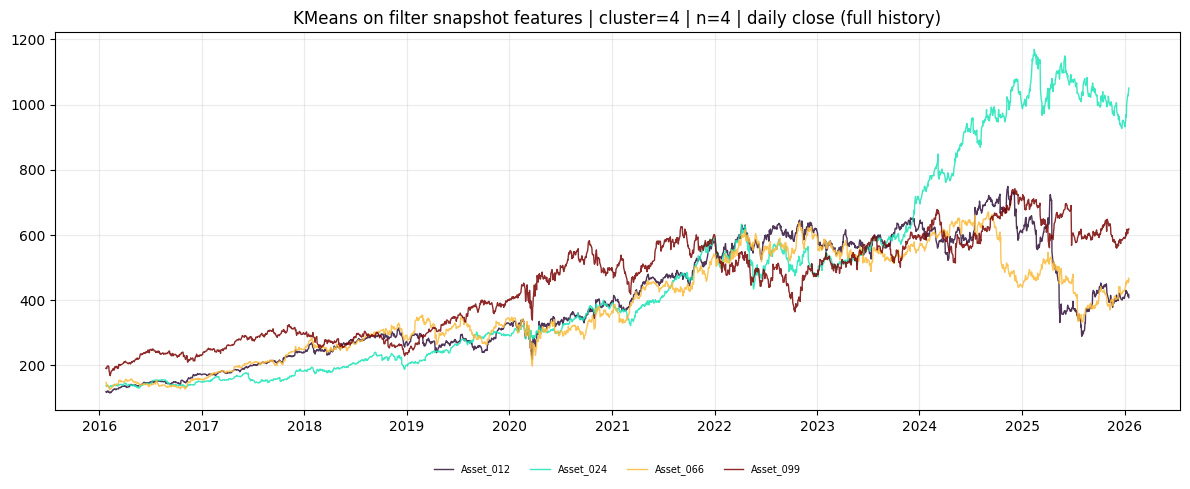

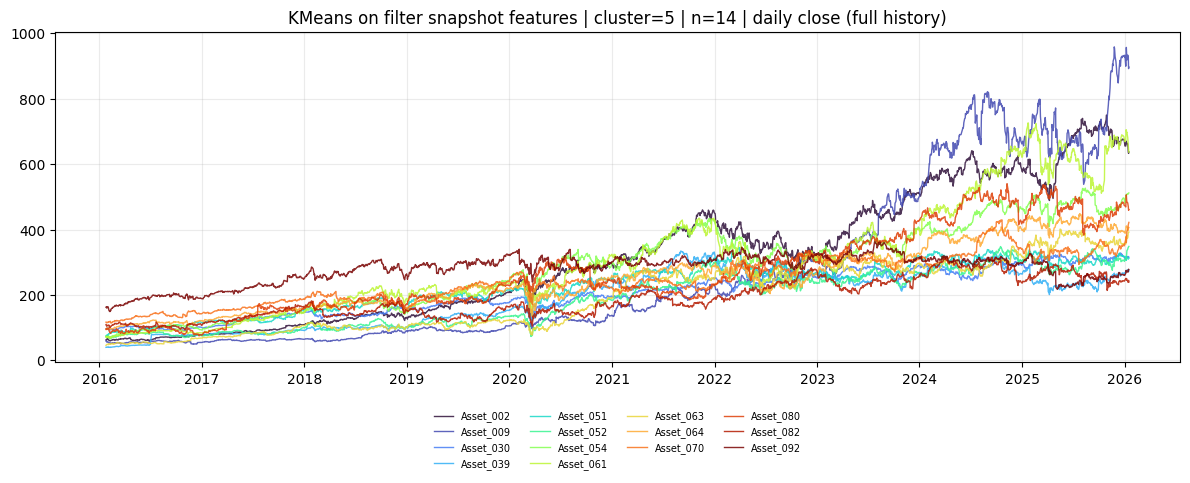

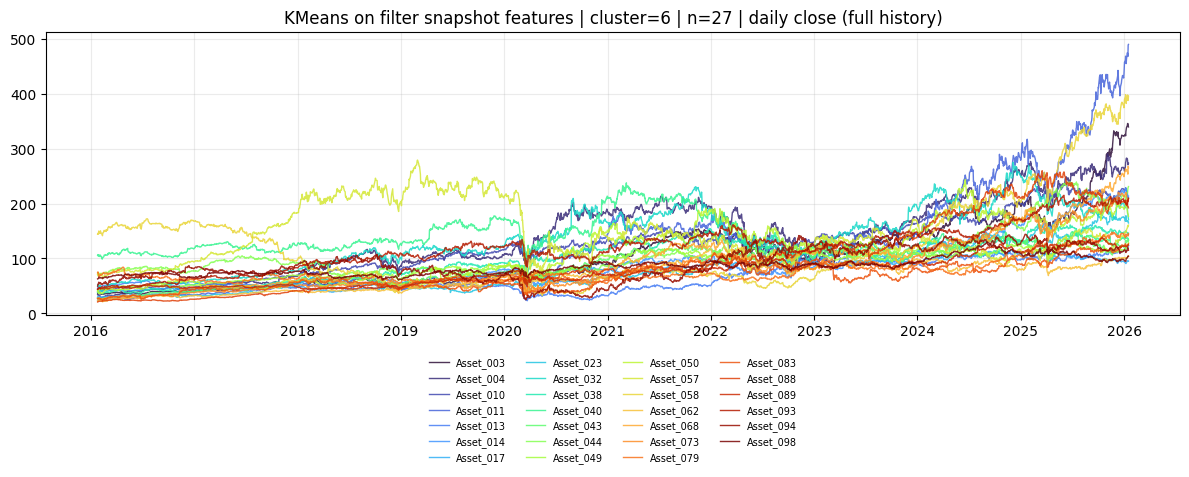

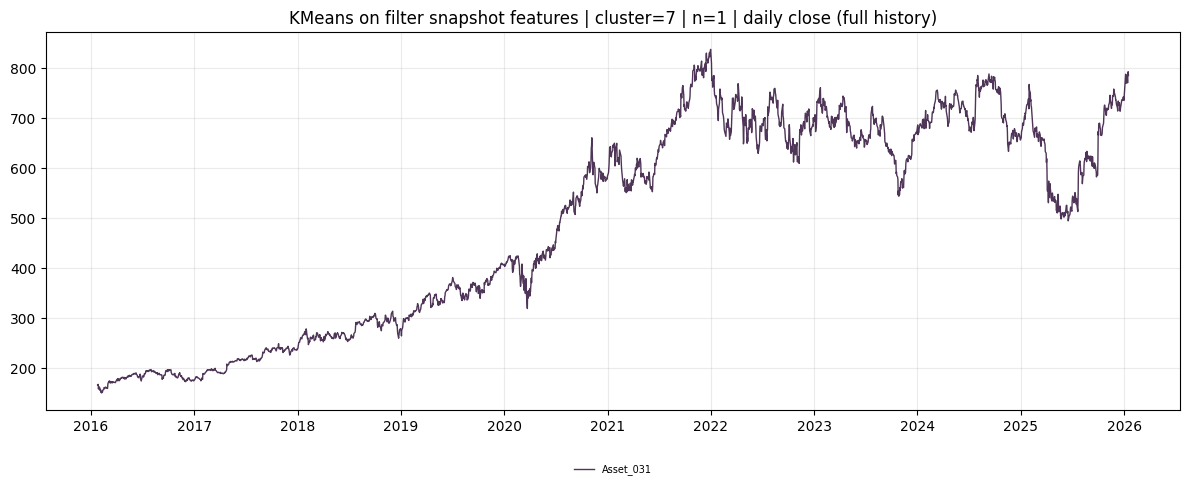

/tmp/ipykernel_149553/815342002.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


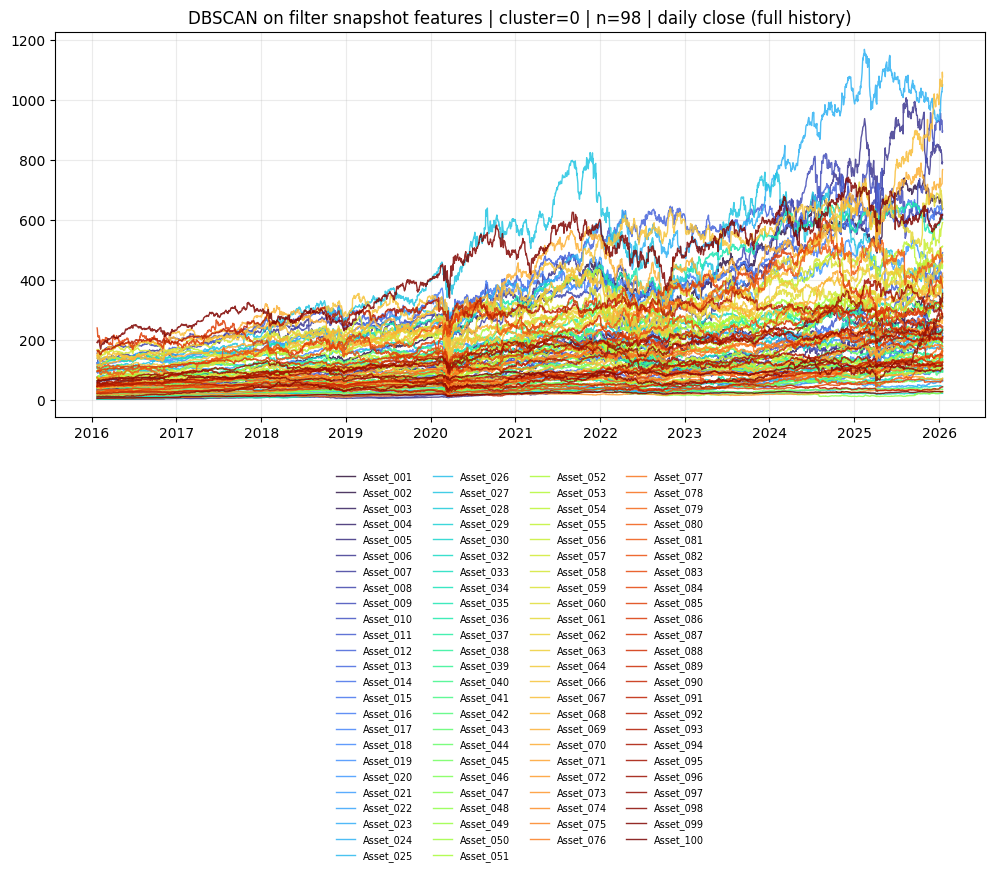

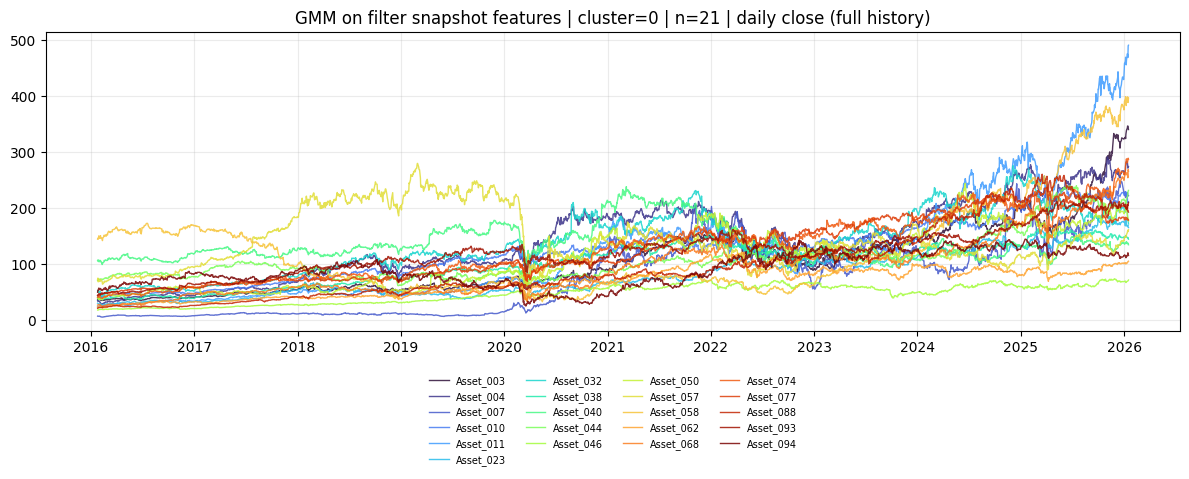

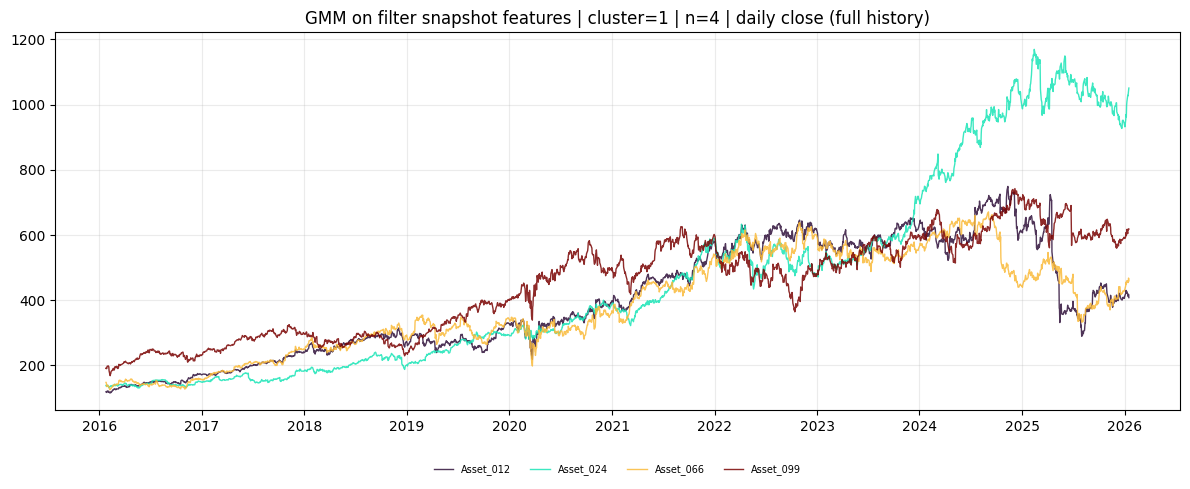

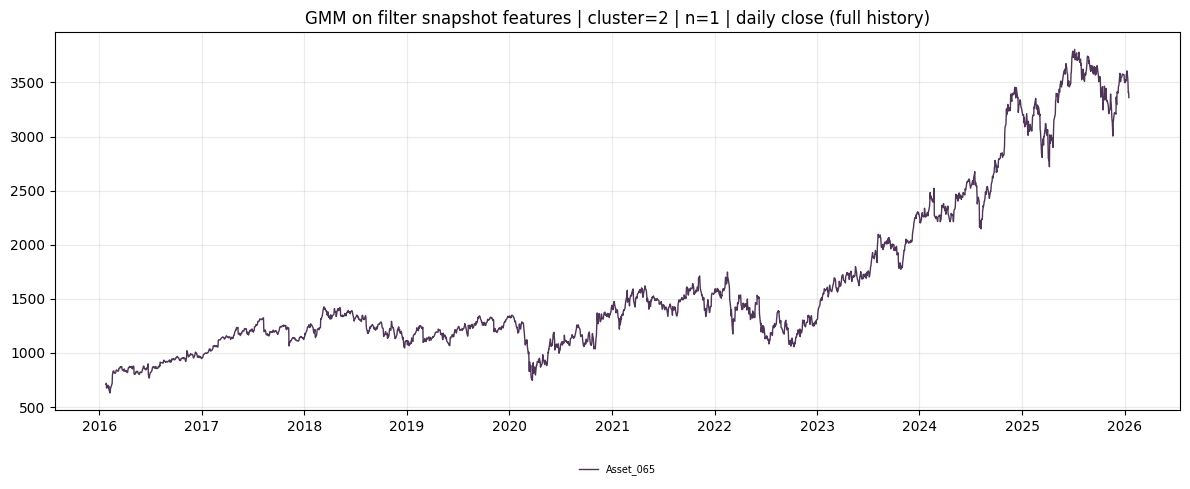

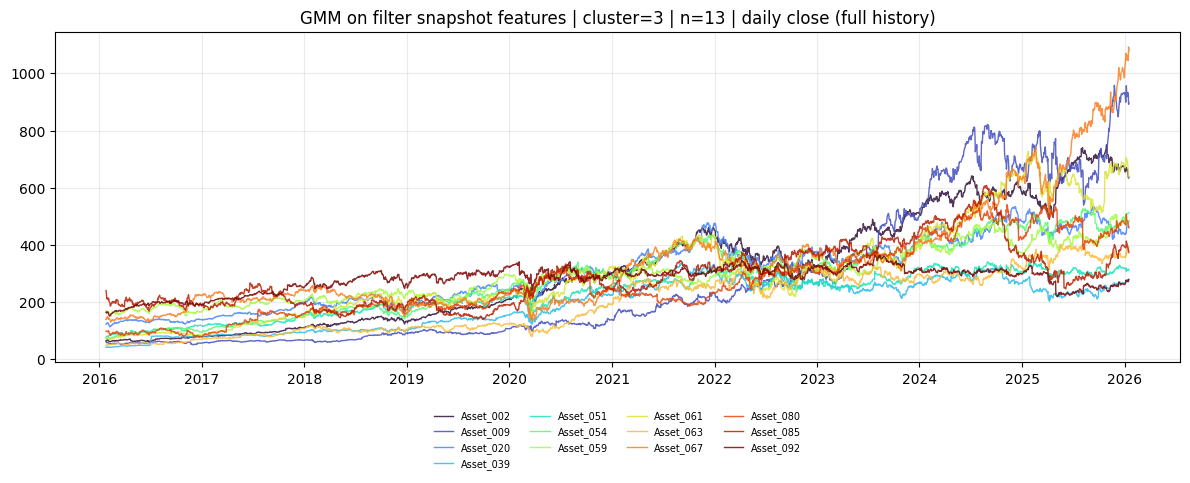

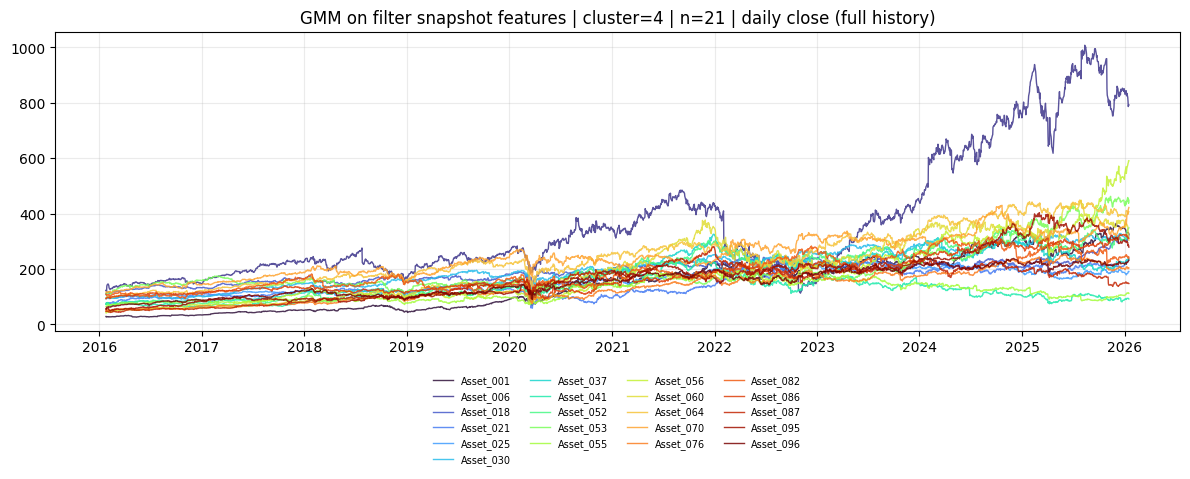

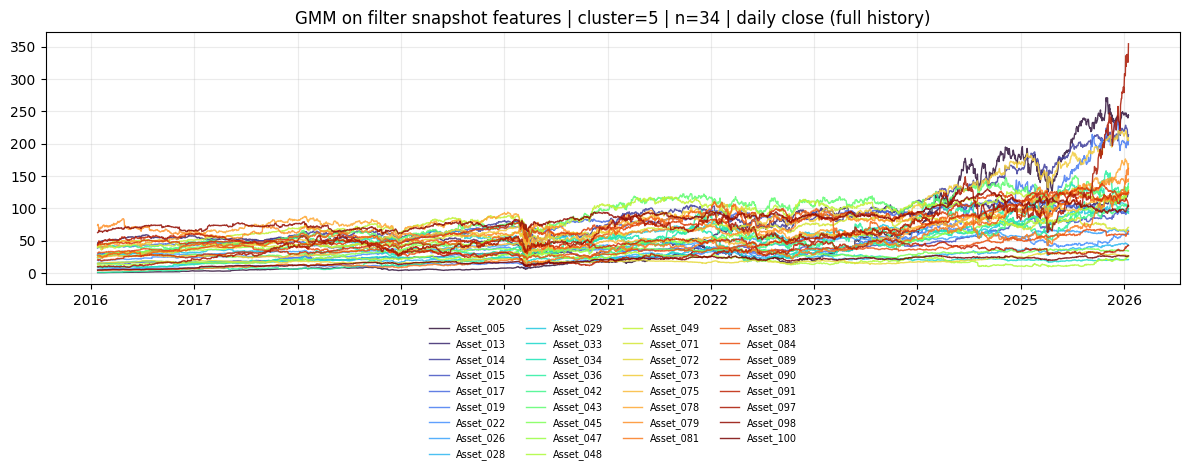

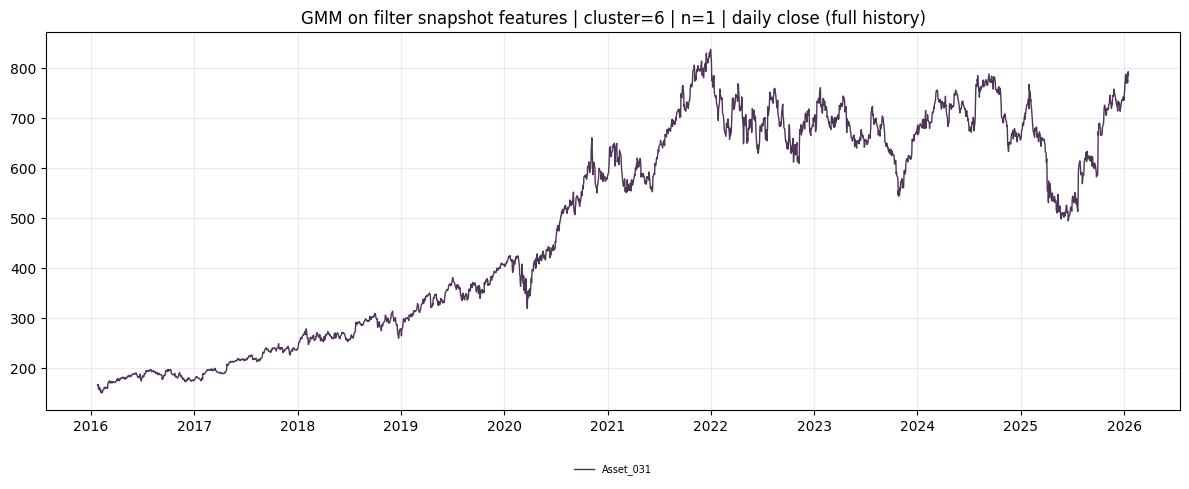

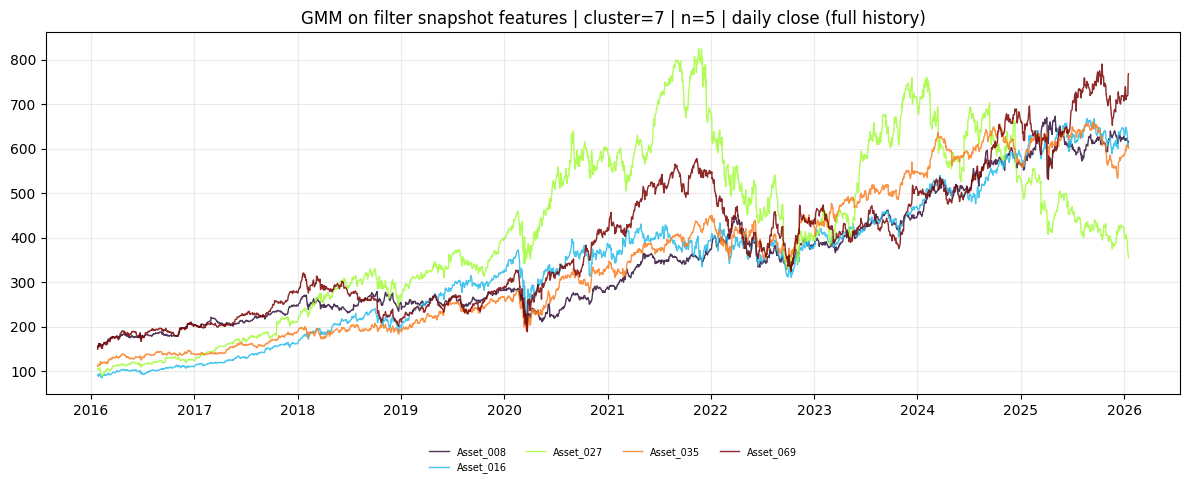

In [8]:
# Plot daily prices by cluster with asset names and colors in legend

def plot_cluster_prices(groups: dict[int, list[str]], close_daily: pd.DataFrame, *, title: str) -> None:
    for cid in sorted(groups.keys()):
        if cid == -1:
            continue
        syms = [s for s in groups[cid] if s in close_daily.columns]
        if len(syms) == 0:
            continue

        colors = plt.cm.turbo(np.linspace(0.0, 1.0, len(syms)))
        plt.figure(figsize=(12, 5))
        for i, s in enumerate(syms):
            plt.plot(close_daily.index, close_daily[s].astype(float), linewidth=1.0, alpha=0.85, color=colors[i], label=str(s))
        plt.title(f'{title} | cluster={cid} | n={len(syms)} | daily close (full history)')
        plt.grid(True, alpha=0.25)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=4, fontsize=7, frameon=False)
        plt.tight_layout()
        plt.show()

plot_cluster_prices(km_groups, close_daily, title='KMeans on filter snapshot features')
plot_cluster_prices({k: v for k, v in db_groups.items() if k != -1}, close_daily, title='DBSCAN on filter snapshot features')
plot_cluster_prices(gmm_groups, close_daily, title='GMM on filter snapshot features')
